In [1]:
!pip install gensim

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [31]:
import pandas as pd
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from textblob import TextBlob
import gensim.downloader as api
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
#import faiss
from sentence_transformers import SentenceTransformer
#from keras.models import Sequential
#from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
#from keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

nlp = spacy.load("en_core_web_sm")

In [59]:
path = "/content/drive/My Drive/capFantasticFour/"
data = pd.read_csv(path +"Datasets/preprocessed.csv")
data

<ipython-input-59-7bce13ee858a>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path +"Datasets/preprocessed.csv")


,Content,Label,Content_int,Cleaned_Content,Preprocessed_Content
0,denial of normal the con be asked to comment o...,1,"[146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,...",denial of normal the con be asked to comment o...,denial normal con ask comment tragedy emotiona...
1,just by being able to tweet this insufferable ...,1,"[146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22...",just by being able to tweet this insufferable ...,able tweet insufferable bullshit proves trump ...
2,that is retarded you too cute to be single tha...,1,"[146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,...",that is retarded you too cute to be single tha...,retard cute single life
3,thought of a real badass mongol style declarat...,1,"[146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,...",thought of a real badass mongol style declarat...,thought real badass mongol style declaration w...
4,afro american basho,1,"[146715, 46, 47, 48, 146714]",afro american basho,afro american basho
...,...,...,...,...,...
440901,crash another movie from left field i have to ...,0,"[146715, 1780, 649, 1673, 347, 701, 1702, 80, ...",crash another movie from left field i have to ...,crash movie left field ask star war episode ii...
440902,i why do not you debate first before starting ...,0,"[146715, 80, 186, 340, 76, 26, 6407, 566, 2608...",i why do not you debate first before starting ...,debate start edit war
440903,removal of i reverted the removal of the above...,0,"[146715, 18731, 1, 80, 48182, 3, 18731, 1, 3, ...",removal of i reverted the removal of the above...,removal revert removal section believe misguid...
440904,i have unblocked you eddie as i discussed on u...,0,"[146715, 80, 87, 20515, 26, 10684, 273, 80, 95...",i have unblocked you eddie as i discussed on u...,unblock eddie discuss user talkable accuse nil...


In [63]:
data = data.drop(["Content_int", "Cleaned_Content", "Preprocessed_Content"], axis = 1) # no need for these now

We will use both spacy and NLTK lemmization to see which is more efficient. One column is lem_spacy_content, lem_nltk and raw is Content.

For word2vec and BERT, the raw `Content` will be used, otherwise, the lemmarization will be used.

In [64]:
print(data.dtypes)
print(data.isnull().sum())

Content    object
Label      object
dtype: object
Content    0
Label      0
dtype: int64


In [65]:
data.describe()

,Content,Label
count,440906,440906
unique,417561,5
top,content,0
freq,7,207120


5 labels issue detected

In [66]:
data['Label'] = pd.to_numeric(data['Label'], errors='coerce')
data['Label'].unique()

array([ 1.,  0., nan])

In [73]:
# remove NAs. either label or content
data = data.dropna()

#data = data.reset_index()
#data = data.drop(columns=["index"])

In [74]:
# Check for duplicate comments
duplicate_rows = data[data.duplicated(subset=['Content'], keep=False)]
print(f'duplicate_rows: {len(duplicate_rows)}')

# Drop duplicate comments
data.drop_duplicates(subset=['Content'], keep='first', inplace=True)

# Confirm duplicates are removed
print("Number of rows after removing duplicates:", len(data))

# Reindex the DataFrame after dropping duplicates
data.reset_index(drop=True, inplace=True)

duplicate_rows: 0
Number of rows after removing duplicates: 417560


In [69]:
#data["Label"] = data["Label"].astype(str)

#data["Label"] = data["Label"].apply(lambda x: 1 if x == '1' else 0 if x == '0' else x)

#data = data[data["Label"].isin([0, 1])]


In [87]:
# WordNet Lemmatization
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def wordnet_lemmatize(text):
    return " ".join([lemmatizer.lemmatize(word, wordnet.VERB) for word in text.split()])


data['lem_nltk'] = [wordnet_lemmatize(text) for text in tqdm(data['Content'], desc='WordNet Lemmatization')]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

WordNet Lemmatization: 100%|██████████| 417560/417560 [01:26<00:00, 4849.66it/s]


In [88]:
# spaCy Lemmatization
import spacy

nlp = spacy.load("en_core_web_sm")

def spacy_lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

data['lem_spacy'] = [spacy_lemmatize(text) for text in tqdm(data['Content'], desc='spaCy Lemmatization')]

spaCy Lemmatization: 100%|██████████| 417560/417560 [1:30:58<00:00, 76.49it/s]


In [75]:
len(data)

417560

In [76]:
data.head()

,Content,Label,lem_content
0,denial of normal the con be asked to comment o...,1.0,denial of normal the con be ask to comment on ...
1,just by being able to tweet this insufferable ...,1.0,just by be able to tweet this insufferable bul...
2,that is retarded you too cute to be single tha...,1.0,that be retard you too cute to be single that ...
3,thought of a real badass mongol style declarat...,1.0,think of a real badass mongol style declaratio...
4,afro american basho,1.0,afro american basho


In [79]:
print(data[data['Label'] == 1]['lem_spacy'].to_numpy()[2168])
print(data[data['Label'] == 1]['lem_nltk'].to_numpy()[2168])
print(data[data['Label'] == 1]['Content'].to_numpy()[2168])

as they should be
as they should be


More fancy exploration

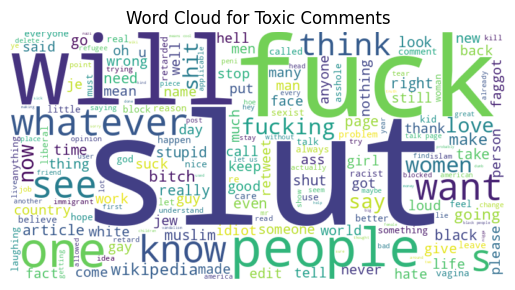

In [83]:
bad_comments = ' '.join(data[data['Label'] == 1]['Content'])


wordcloud_bad = WordCloud(width=800, height=400, background_color='white').generate(bad_comments)
plt.imshow(wordcloud_bad, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Toxic Comments')
plt.show()

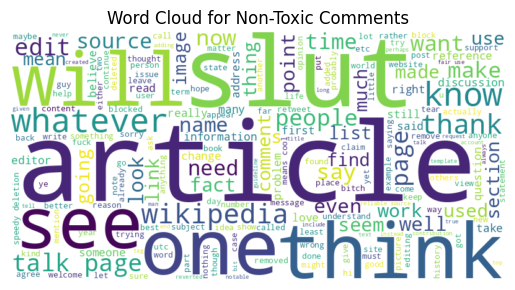

In [84]:
ok_comments = ' '.join(data[data['Label'] == 0]['Content'])
wordcloud_non_toxic = WordCloud(width=800, height=400, background_color='white').generate(ok_comments)
plt.imshow(wordcloud_non_toxic, interpolation='bilinear')

plt.axis('off')
plt.title('Word Cloud for Non-Toxic Comments')
plt.show()

In [85]:
hate_speech_words = [
    'hate', 'violence', 'abuse', 'offend', 'discrimination', 'racism', 'oppression', 'bigot', 'ignorant',
    'supremacist', 'feminazi', 'cunt', 'slut', 'whore', 'bitch', 'skank', 'thot', 'ho', 'gold digger',
    'motherfucker', 'cockroach', 'asshole', 'dickhead', 'prick', 'scumbag', 'bastard', 'fuck', 'nigga',
    'nigger', 'chink', 'gook', 'spic', 'wetback', 'cracker', 'honky', 'kike', 'wog', 'towelhead',
    'sandnigger', 'faggot', 'fag', 'dyke', 'tranny', 'homo', 'sissy', 'fairy', 'pansy', 'sodomite',
    'infidel', 'heathen', 'crusader', 'raghead', 'jihadist', 'taliban', 'beaner', 'gypsy', 'paki',
    'wop', 'dago', 'mick', 'jap', 'yid', 'kaffir', 'cholo', 'zebra', 'white trash', 'redneck', 'hillbilly',
    'karen', 'snowflake', 'beta', 'incel', 'simp', 'boomer', 'npc', 'soyboy', 'mgtow', 'swine', 'trumpist',
    'libtard', 'nazi', 'commie', 'sjw', 'ratchet', 'ghetto', 'redpill', 'based', 'chad', 'beta male',
    'alpha male', 'cuck', 'cock', 'broke bitch', 'pussy ass', 'turd', 'feminist', 'terrorist', 'islamist'
]

word2vec_model = api.load("word2vec-google-news-300")

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')


In [86]:
def sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def detect_hate_speech(text):
    return sum([1 for word in hate_speech_words if word in text.lower()])

def pos_tagging(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    return pos_tags

def get_word2vec_embedding(text):
    tokens = [token.text.lower() for token in nlp(text)]
    word_vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

def lexical_diversity(text):
    tokens = [token.text for token in nlp(text)]
    return len(set(tokens)) / len(tokens) if len(tokens) > 0 else 0

def sentence_complexity(text):
    return len(re.findall(r'\.', text))

def get_sbert_embedding(text):
    return sbert_model.encode(text, convert_to_numpy=True)


In [58]:
# Feature extraction
data['sentiment'] = data['lem_spacy'].apply(sentiment_analysis)
print('Sentiment analysis done')

data['hate_speech_count'] = data['lem_spacy'].apply(detect_hate_speech)
print('Hate speech detection done')

data['pos_tags'] = data['Preprocessed_Content'].apply(pos_tagging)
print('POS tagging detection done')

data['word2vec'] = data['Content'].apply(get_word2vec_embedding)
print('Word2Vec embedding done')

data['sbert_embedding'] = data['Content'].apply(get_sbert_embedding)
print('SBERT embedding done')

data['lexical_diversity'] = data['Preprocessed_Content'].apply(lexical_diversity)
print('Lexical diversity done')

data['sentence_complexity'] = data['Preprocessed_Content'].apply(sentence_complexity)
print('Sentence complexity done')



TypeError: The `text` argument passed to `__init__(text)` must be a string, not <class 'float'>

In [ ]:
data.to_csv(path+"Datasets/features.csv", index=False)

In [ ]:
#remove duplicate rows
data = data.drop_duplicates(subset=['Preprocessed_Content'])

### Drop unnecessary columns

In [ ]:
data = data.drop(columns=['Content', 'Content_int', 'Cleaned_Content', 'Preprocessed_Content'])

In [ ]:
data.columns

Index(['Label', 'sentiment', 'hate_speech_count', 'pos_tags', 'word2vec',
       'sbert_embedding', 'lexical_diversity', 'sentence_complexity'],
      dtype='object')

In [ ]:
len(data)

407364

### Save the dataset with extracted features

In [ ]:
data.to_csv("Datasets/features.csv", index=False)